<a href="https://colab.research.google.com/github/KLeeDE/ResearchProj_UrbanHeat/blob/master/2D-CNN/2020_10_05__source_selection_Kyungmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Singapore IR Source Selection**

*September 24, 2020*

This notebook will try to slect air con source pixels based on their time series using supervised learning techniques.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import time
import numpy as np
import pandas as pd
import imageio as iio
from imageio import imread
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

First of all, we want to put our data into the classical $N_{obj} \times N_{feat}$ format.

Load in the imaging data.

In [ ]:
# -- set the file names
pname = "/content/drive/My Drive/urban_heat/output/paths_times.csv"
fpaths = pd.read_csv(pname)
fpaths = fpaths[(fpaths.time >= "2020-03-14 00:00:00") & 
                (fpaths.time < "2020-03-14 04:00:00")]
fpaths = fpaths.path.values

print("there are {0} files between midnight and 4am on 03/14/20" \
      .format(len(fpaths)))

there are 1435 files between midnight and 4am on 03/14/20


In [ ]:
# -- read in the 0th image
img0 = np.asarray(iio.imread(fpaths[0]))[:, :, 0] / 255.
nrow, ncol = img0.shape
nrow, ncol

(240, 320)

In [ ]:
# -- initialize an array to hold all of the images
imgs = np.zeros((len(fpaths), nrow, ncol))

for ii, fname in enumerate(fpaths):
  if ii % 20 == 0:
    print("working on the {0} image".format(ii))

  imgs[ii, :, :] = np.asarray(iio.imread(fname))[:, :, 0] / 255.

working on the 0 image
working on the 20 image
working on the 40 image
working on the 60 image
working on the 80 image
working on the 100 image
working on the 120 image
working on the 140 image
working on the 160 image
working on the 180 image
working on the 200 image
working on the 220 image
working on the 240 image
working on the 260 image
working on the 280 image
working on the 300 image
working on the 320 image
working on the 340 image
working on the 360 image
working on the 380 image
working on the 400 image
working on the 420 image
working on the 440 image
working on the 460 image
working on the 480 image
working on the 500 image
working on the 520 image
working on the 540 image
working on the 560 image
working on the 580 image
working on the 600 image
working on the 620 image
working on the 640 image
working on the 660 image
working on the 680 image
working on the 700 image
working on the 720 image
working on the 740 image
working on the 760 image
working on the 780 image
workin

In [ ]:
# -- read in the labeled pixels
acs = np.load("/content/drive/My Drive/urban_heat/output/acs_pix.npy")
bld = np.load("/content/drive/My Drive/urban_heat/output/bld_pix.npy")
sky = np.load("/content/drive/My Drive/urban_heat/output/sky_pix.npy")
win = np.load("/content/drive/My Drive/urban_heat/output/win_pix.npy")

In [ ]:
# -- convert to pixel numbers
acs_col, acs_row = acs.round().astype(int).T
bld_col, bld_row = bld.round().astype(int).T
sky_col, sky_row = sky.round().astype(int).T
win_col, win_row = win.round().astype(int).T

Now that we have the pixel locations of the labeled data, let's extract the features from the images array,

In [ ]:
acs_row.size

30

In [ ]:
# -- extract features from images
feat_acs = imgs[:, acs_row, acs_col].T
feat_bld = imgs[:, bld_row, bld_col].T
feat_sky = imgs[:, sky_row, sky_col].T
feat_win = imgs[:, win_row, win_col].T

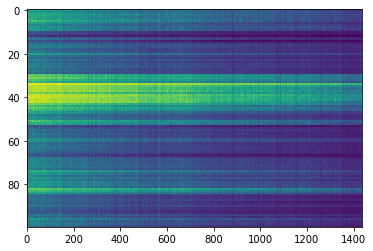

In [ ]:
plt.imshow(feat_bld, aspect="auto", interpolation="nearest")

In [ ]:
# -- stack together into one big feature matrix
feat = np.vstack([feat_acs, feat_bld, feat_sky, feat_win])

# -- standardize the features
feat = (feat - feat.mean(axis=1, keepdims=True)) / feat.std(axis=1, keepdims=True)

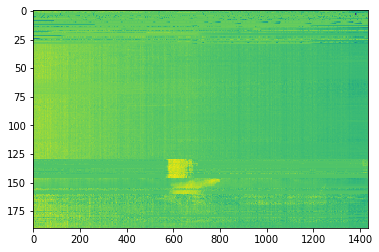

In [ ]:
plt.imshow(feat, aspect="auto", interpolation="nearest")

In [ ]:
# -- initialize target array
labs_acs = np.zeros(acs.shape[0])
labs_bld = np.zeros(bld.shape[0]) + 1
labs_sky = np.zeros(sky.shape[0]) + 2
labs_win = np.zeros(win.shape[0]) + 3
targ = np.hstack([labs_acs, labs_bld, labs_sky, labs_win])

In [ ]:
# -- create a training/testing sample
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ, random_state=314)

In [ ]:
# -- train a Random Forest Classifier
rfc = RandomForestClassifier(min_samples_leaf=3)
rfc.fit(feat_tr, targ_tr)

# -- test the accuracy
pred_tr = rfc.predict(feat_tr)
pred_te = rfc.predict(feat_te)
acc_tr = ((pred_tr - targ_tr) != 0).sum() / len(targ_tr)
acc_te = ((pred_te - targ_te) != 0).sum() / len(targ_te)

print("training accuracy : {0}".format(1.0 - acc_tr))
print("testing accuracy  : {0}".format(1.0 - acc_te))

training accuracy : 1.0
testing accuracy  : 0.9166666666666666


Now let's predict on all pixels

In [ ]:
# -- convert images into all features
feat_all = imgs.reshape(imgs.shape[0], nrow * ncol).T

feat_all = (feat_all - feat_all.mean(axis=1, keepdims=True)) / feat_all.std(axis=1, keepdims=True)

In [ ]:
# -- predict all
pred_all = rfc.predict(feat_all)

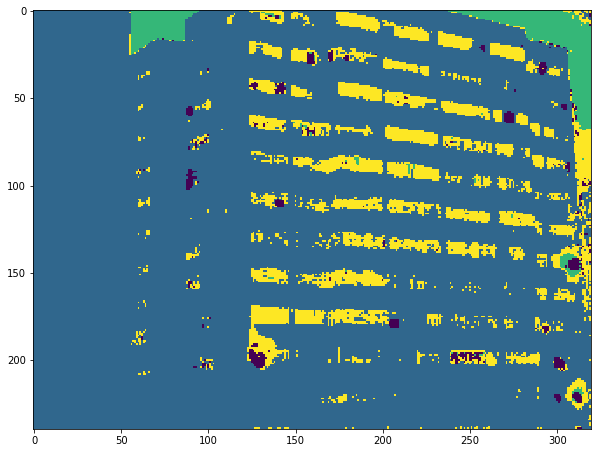

In [ ]:
# -- show the predictions
pimg = pred_all.reshape(nrow, ncol)

plt.figure(figsize=(10, 10))
plt.imshow(pimg, interpolation="nearest")
plt.show()

# **Convolutional Neural Network (CNN)**

Prepared by Kyungin Lee

Oct 8, 2020

## Prepare the data for use with a TEnsorflow/Keras CNN

In [ ]:
# -- read in the images using np.load
# -- read in the labeled pixels
acs = np.load("/content/drive/My Drive/urban_heat/output/acs_pix.npy")
bld = np.load("/content/drive/My Drive/urban_heat/output/bld_pix.npy")
sky = np.load("/content/drive/My Drive/urban_heat/output/sky_pix.npy")
win = np.load("/content/drive/My Drive/urban_heat/output/win_pix.npy")

In [ ]:
# -- determine the shape of these images so that we know how to set up the convnet
acs_sh = acs.shape
bld_sh = bld.shape
sky_sh = sky.shape
win_sh = win.shape
acs_sh, bld_sh, sky_sh, win_sh

((30, 2), (100, 2), (30, 2), (30, 2))

In [ ]:
feat = np.vstack([feat_acs, feat_bld, feat_sky, feat_win])
print(feat.shape)

(190, 1435)


### Random Forest Classifier

In [ ]:
# -- create a training/testing sample
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ, random_state=314)

In [ ]:
# -- train a Random Forest Classifier
rfc = RandomForestClassifier(min_samples_leaf=3)
rfc.fit(feat_tr, targ_tr)

# -- test the accuracy
pred_tr = rfc.predict(feat_tr)
pred_te = rfc.predict(feat_te)
acc_tr = ((pred_tr - targ_tr) != 0).sum() / len(targ_tr)
acc_te = ((pred_te - targ_te) != 0).sum() / len(targ_te)

print("training accuracy : {0}".format(1.0 - acc_tr))
print("testing accuracy  : {0}".format(1.0 - acc_te))

training accuracy : 0.9929577464788732
testing accuracy  : 0.9583333333333334


### Convolutional Neural Network

In [ ]:
# create a target array corresponding to the loaded images 
nacs = acs.shape[0]
targ_cnn = np.zeros(len(feat), dtype=int)
targ_cnn[:nacs] = 1

In [ ]:
# -- generate an 80/20 training/testing split
featc_tr, featc_te, targc_tr, targc_te = train_test_split(feat, targ_cnn, test_size=0.20, random_state=314)
print(feat.shape)
print(targ_cnn.shape)
print(featc_tr.shape)
print(targc_tr.shape)
print(featc_te.shape)
print(targc_te.shape)

(190, 1435)
(190,)
(152, 1435)
(152,)
(38, 1435)
(38,)


In [ ]:
feat

array([[0.35686275, 0.40392157, 0.36862745, ..., 0.7372549 , 0.76078431,
        0.71372549],
       [0.96470588, 0.94901961, 0.95294118, ..., 0.80784314, 0.76862745,
        0.76470588],
       [0.96862745, 0.97647059, 0.98823529, ..., 0.92156863, 0.90196078,
        0.91764706],
       ...,
       [0.38039216, 0.38431373, 0.39607843, ..., 0.28627451, 0.28627451,
        0.28627451],
       [0.37647059, 0.37647059, 0.37647059, ..., 0.28235294, 0.28627451,
        0.27843137],
       [0.34117647, 0.37254902, 0.36078431, ..., 0.29019608, 0.28235294,
        0.28235294]])

In [ ]:
targ_cnn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Build a tensorflow CNN

### Change from 2D to 1D

* In 1D CNN, kernel moves in 1 direction. Input and output data of 1D CNN is 2 dimensional. Mostly used on Time-Series data.

* In 2D CNN, kernel moves in 2 directions. Input and output data of 2D CNN is 3 dimensional. Mostly used on Image data.

* In 3D CNN, kernel moves in 3 directions. Input and output data of 3D CNN is 4 dimensional. Mostly used on 3D Image data (MRI, CT Scans, Video).

In [ ]:
import keras
from keras.layers import Conv1D, Flatten

In [ ]:
model = keras.models.Sequential()
model.add(Conv1D(1, kernel_size=5, input_shape = (120,3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 116, 1)            16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


* INPUT [32x32x3] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.

* CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.

* RELU layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).

* POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].

* FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.


* Argument "input_shape (n_timesteps, n_features)"

* Argument kernel_size is 3, representing the width of the kernel, and kernel height will be the same as the number of data points in each time step.

In [ ]:
featc_tr.shape

(152, 1435)

In [ ]:
targc_tr.shape

(152,)

In [ ]:
## Change from 2D to 1D

# -- define layers/architecture
conv0  = keras.layers.Conv1D(filters=32, kernel_size= 3, padding="same", activation="relu", input_shape=(1435, 1))
pool0  = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')
conv1  = keras.layers.Conv1D(filters=64, kernel_size= 3, padding="same", activation="relu")
pool1  = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')
flat   = keras.layers.Flatten()
fconn  = keras.layers.Dense(1024, activation="relu")
output = keras.layers.Dense(4, activation="softmax")
drop   = keras.layers.Dropout(0.5)
layers = [conv0, pool0, drop, conv1, pool1, drop, flat, fconn, drop, output]

# -- instantiate the model
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# reshape 
nobj1 = featc_tr.shape[0]
nfeat1 = featc_tr.shape[1]
featc_tr = featc_tr.reshape(nobj1, nfeat1, 1)
nobj2 = featc_te.shape[0]
nfeat2 = featc_te.shape[1]
featc_te = featc_te.reshape(nobj2, nfeat2, 1)

# -- fit the training data
history = model.fit(featc_tr, targc_tr, epochs=20, batch_size=10)

loss_tr, acc_tr = model.evaluate(featc_tr, targc_tr)
loss_te, acc_te = model.evaluate(featc_te, targc_te)


print("TRAINING accuracy : {0:.4f}".format(acc_tr))
print("TESTING accuracy  : {0:.4f}".format(acc_te))

Epoch 1/20
16/16 [==============================] - 3s 180ms/step - loss: 1.3672 - accuracy: 0.6382
Epoch 2/20
16/16 [==============================] - 3s 180ms/step - loss: 0.6724 - accuracy: 0.8487
Epoch 3/20
16/16 [==============================] - 3s 183ms/step - loss: 0.1776 - accuracy: 0.9276
Epoch 4/20
16/16 [==============================] - 3s 182ms/step - loss: 0.1738 - accuracy: 0.9079
Epoch 5/20
16/16 [==============================] - 3s 183ms/step - loss: 0.1249 - accuracy: 0.9605
Epoch 6/20
16/16 [==============================] - 3s 183ms/step - loss: 0.1351 - accuracy: 0.9474
Epoch 7/20
16/16 [==============================] - 3s 184ms/step - loss: 0.0854 - accuracy: 0.9671
Epoch 8/20
16/16 [==============================] - 3s 184ms/step - loss: 0.1193 - accuracy: 0.9474
Epoch 9/20
16/16 [==============================] - 3s 187ms/step - loss: 0.1050 - accuracy: 0.9342
Epoch 10/20
16/16 [==============================] - 3s 183ms/step - loss: 0.0950 - accuracy: 0.9605

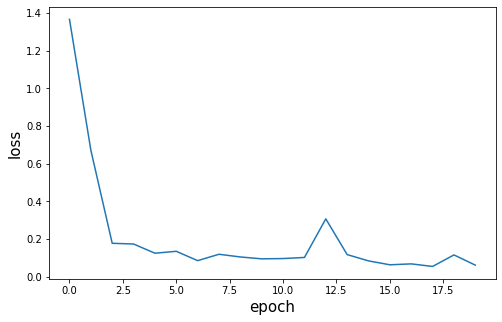

In [ ]:
# -- plot the loss function
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(history.history["loss"])
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("loss", fontsize=15)
fig.show()

## Mdoel performance evaluation

In [ ]:
from sklearn.metrics import confusion_matrix

# -- predict the training data
predc_te = model.predict(featc_te)

# -- set a threshold for detection
thresh = 0.99

# -- determine the confusion matrix
conf = confusion_matrix(targc_te, predc_te[:, 1] > thresh)

print("confusion matrix : \n{0}".format(conf))

confusion matrix : 
[[30  0]
 [ 8  0]]


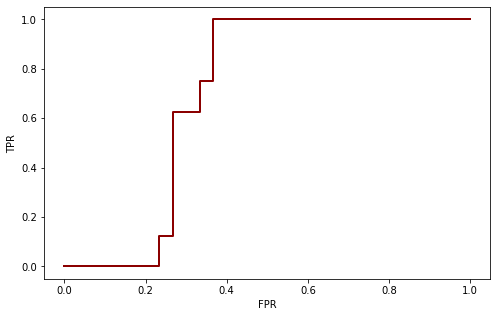

In [ ]:
from sklearn.metrics import roc_curve

# -- generate ROC curve
pred_te = model.predict(featc_te)
roc = roc_curve(targc_te, predc_te[:, 1])

# -- plot it
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(roc[0], roc[1], color="darkred", lw=2)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
fig.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# -- calculate precision and recall
pred_img = 1 * (predc_te[:, 0] < predc_te[:, 1])
prec, recall, fbeta, support = precision_recall_fscore_support(targc_te, pred_img)

print("precision : {0:.3f}".format(prec[1]))
print("recall    : {0:.3f}".format(recall[1]))
print("support   : {0}".format(support))

precision : 0.000
recall    : 0.000
support   : [30  8]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Use this trained network to predict all pixels

In [ ]:
# -- convert images into all features
feat_all = imgs.reshape(imgs.shape[0], nrow * ncol).T
feat_all = (feat_all - feat_all.mean(axis=1, keepdims=True)) / feat_all.std(axis=1, keepdims=True)

In [ ]:
# -- predict all
pred_all = rfc.predict(feat_all)

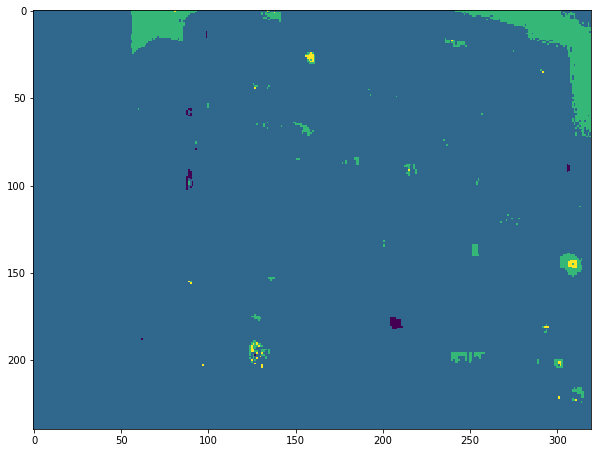

In [ ]:
# -- show the predictions
pimg = pred_all.reshape(nrow, ncol)

plt.figure(figsize=(10, 10))
plt.imshow(pimg, interpolation="nearest")
plt.show()

In [ ]:
## Original

# -- define layers/architecture
conv0  = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(50, 50, 3))
pool0  = keras.layers.MaxPooling2D((2, 2), strides=2)
conv1  = keras.layers.Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu")
pool1  = keras.layers.MaxPooling2D((2, 2), strides=2)
flat   = keras.layers.Flatten()
fconn  = keras.layers.Dense(1024, activation="relu")
output = keras.layers.Dense(2, activation="softmax")
#drop   = keras.layers.Dropout(0.5)
#layers = [conv0, pool0, drop, conv1, pool1, drop, flat, fconn, drop, output]

# -- instantiate the model
#model = keras.Sequential(layers)
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- fit the training data
#history = model.fit(featc_tr, targc_tr, epochs=20, batch_size=10)

#loss_tr, acc_tr = model.evaluate(featc_tr, targc_tr)
#loss_te, acc_te = model.evaluate(featc_te, targc_te)

#print("TRAINING accuracy : {0:.4f}".format(acc_tr))
#print("TESTING accuracy  : {0:.4f}".format(acc_te))

In [ ]:
# -- set the path to the full image set
fpath = "drive/My Drive/urban_heat/data/singapore_ir/03-14/"

In [ ]:
# -- get the file list for the full image set
flist = glob.glob(fpath + "*")

In [ ]:
# -- read in a random image from the full image set using imread
#    convert the image to float then minmax normalize it
full = imread(flist[0]).astype(float)
full /= full.max()

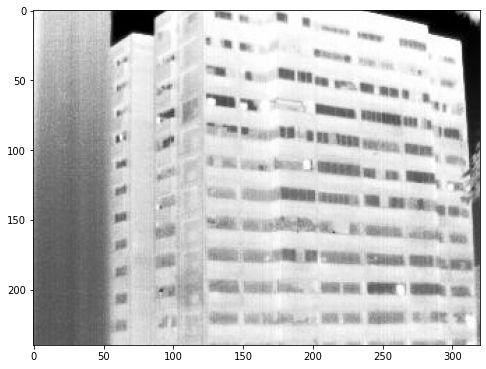

In [ ]:
# -- visulize the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(full)
fig.show()

In [ ]:
# -- separate the image into 50x50 stamps
nrow = full.shape[0]
ncol = full.shape[1]

In [ ]:
# -- plot an example
plt.imshow(stamps[0])

NameError: ignored

In [ ]:
# -- feed the stamps through the model
pred_stamps = model.predict(stamps)

In [ ]:
pred_stamps

In [ ]:
# -- reshape into a "detection image"
pred_image = pred_stamps[:, 1].reshape(nrow-50, ncol-50)

In [ ]:
# -- visualize the results
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(full)
ax[1].imshow(pred_image > 0.8, "gist_gray")
fig.show()